In [1]:
import netCDF4
import numpy as np
import pandas as pd
import os
import xarray as xr
from fbprophet.utilities import regressor_coefficients
import pandas as pd
from fbprophet import Prophet


Importing plotly failed. Interactive plots will not work.


In [2]:
f_names = os.listdir("../data")
f_names = filter(lambda f:"nc4" in f,f_names)
def load_netcdf(f_path:str)-> pd.DataFrame:
    ds = xr.open_dataset(f_path)
    df = ds.to_dataframe()
    return df
dfs = [load_netcdf(os.path.join("../data",f_name)) for f_name in f_names]

In [3]:
data = pd.concat(dfs)

In [4]:
data = data.sort_index()

In [5]:
data.columns
data.drop(['LWGAB', 
           'CLDTOT', 
           'ALBNIRDF',
           'LWTUPCLRCLN',
           'CLDHGH', 
           'LWGABCLR', 
           'LWGABCLRCLN', 
           'LWGNTCLRCLN', 
           'LWGEM', 
           'CLDMID',
           'TS',
            "ALBVISDF",
           "ALBNIRDR",
           "ALBVISDR",
           "EMIS",
          "LWGNTCLR",
          "LWGNT",
          "LWTUPCLR",
          "LWTUP"],axis=1,inplace=True)

In [6]:
data_terminator = data.query('lat > -66 & lat <66')

In [7]:
def lat_weight(lat:float) -> float:
    return abs(np.sin(np.radians(lat-0.5))-np.sin(np.radians(lat+0.5)))

In [8]:
weights = []
for index, group in data_terminator.groupby(level="lat"):
    weight = lat_weight(index)
    weights.append(weight)

In [9]:
i=0 
for index, group in data_terminator.groupby(level="lat"):
    data_terminator.loc[(slice(None), index,slice(None)),"weights"] = weights[i] 
    i+=1


/var/folders/8_/qfq2f03j40x2lyrbnm67xqm40000gn/T/ipykernel_20474/1685869397.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_terminator.loc[(slice(None), index,slice(None)),"weights"] = weights[i]


In [10]:
data_terminator

SWTDN    SWTNTCLR  SWGNTCLRCLN  \
time                lat   lon                                             
1980-01-01 00:30:00 -65.5 -180.000  466.912994  406.787567   328.826385   
                          -179.375  466.915222  406.476318   328.580505   
                          -178.750  466.915039  406.453522   328.634583   
                          -178.125  466.906097  406.475830   328.728149   
                          -177.500  466.904846  406.426697   328.730927   
...                                        ...         ...          ...   
2022-09-01 00:30:00  65.5  176.875  211.141174  166.969925   124.625114   
                           177.500  211.138702  166.981583   124.644463   
                           178.125  211.130600  166.877335   124.573555   
                           178.750  211.125717  166.391251   124.193268   
                           179.375  211.115021  167.261124   125.107368   

                                         SWGNT    ALBEDO    SWGNTCLR  \
time                lat   lon                                          
1980-01-01 00:30:00 -65.5 -180.000  161.472748  0.085438  324.064026   
                          -179.375  160.354431  0.085887  323.768097   
                          -178.750  160.216049  0.085753  323.755157   
                          -178.125  160.149765  0.085414  323.790466   
                          -177.500  159.748947  0.084808  323.744293   
...                                        ...       ...         ...   
2022-09-01 00:30:00  65.5  176.875   69.678993  0.162984  121.806190   
                           177.500   70.104691  0.163344  121.836632   
                           178.125   69.810463  0.164202  121.768669   
                           178.750   67.430260  0.167300  121.366486   
                           179.375   67.576347  0.160683  122.211433   

                                      SWGNTCLN    SWGDNCLR    CLDLOW  \
time                lat   lon                                          
1980-01-01 00:30:00 -65.5 -180.000  162.907516  350.770599  0.729534   
                          -179.375  161.784744  350.726746  0.736277   
                          -178.750  161.671936  350.609161  0.742577   
                          -178.125  161.621979  350.455048  0.749367   
                          -177.500  161.240280  350.312408  0.753717   
...                                        ...         ...       ...   
2022-09-01 00:30:00  65.5  176.875   70.966972  144.213120  0.403779   
                           177.500   71.393974  144.304703  0.406561   
                           178.125   71.090599  144.362473  0.420616   
                           178.750   68.671440  144.389175  0.458189   
                           179.375   68.827866  144.301971  0.469199   

                                    SWTNTCLRCLN       SWGDN    SWTNTCLN  \
time                lat   lon                                             
1980-01-01 00:30:00 -65.5 -180.000   410.539124  174.709641  254.506409   
                          -179.375   410.279510  173.665863  253.477585   
                          -178.750   410.311096  173.448090  253.429703   
                          -178.125   410.394684  173.235153  253.457718   
                          -177.500   410.389282  172.693176  253.162369   
...                                         ...         ...         ...   
2022-09-01 00:30:00  65.5  176.875   168.791641   82.961716  114.770157   
                           177.500   168.800323   83.474632  115.196457   
                           178.125   168.704269   83.205879  114.908760   
                           178.750   168.245728   80.711800  112.544067   
                           179.375   169.191559   80.255501  112.699402   

                                         SWTNT   weights  
time                lat   lon                             
1980-01-01 00:30:00 -65.5 -180.000  254.101288  0.007238  
                          -179.375  25

In [11]:
data_terminator['wtoa_sw_all_mon']=data_terminator['SWTNT']*data_terminator['weights']

data_terminator['wtoa_sw_clr_c_all_mon']=data_terminator['SWTNTCLRCLN']*data_terminator['weights']
data_terminator['wsolar_mon']=data_terminator['SWTDN']*data_terminator['weights']

/var/folders/8_/qfq2f03j40x2lyrbnm67xqm40000gn/T/ipykernel_20474/4287589072.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_terminator['wtoa_sw_all_mon']=data_terminator['SWTNT']*data_terminator['weights']
/var/folders/8_/qfq2f03j40x2lyrbnm67xqm40000gn/T/ipykernel_20474/4287589072.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_terminator['wtoa_sw_clr_c_all_mon']=data_terminator['SWTNTCLRCLN']*data_terminator['weights']
/var/folders/8_/qfq2f03j40x2lyrbnm67xqm40000gn/T/ipykernel_20474/42875

#  Albedo  MERRA-2 vs. CERES

In [12]:
data_agg = data_terminator.groupby(level="time").mean()
data_agg["absorb"] = data_agg['wtoa_sw_all_mon']/data_agg['wsolar_mon']

In [13]:
data_agg["albedo"] = 1 - data_agg["absorb"]

In [14]:
data_agg.index  = pd.to_datetime(data_agg.index)


In [89]:
data_agg

,SWTDN,SWTNTCLR,SWGNTCLRCLN,SWGNT,ALBEDO,SWGNTCLR,SWGNTCLN,SWGDNCLR,CLDLOW,SWTNTCLRCLN,SWGDN,SWTNTCLN,SWTNT,weights,wtoa_sw_all_mon,wtoa_sw_clr_c_all_mon,wsolar_mon,absorb,albedo
time,,,,,,,,,,,,,,,,,,,
1980-01-01,349.535645,304.126495,239.131439,171.254547,0.138276,234.457275,174.358002,258.841675,0.296448,307.034576,189.368576,244.568436,243.098038,0.013867,3.571863,4.428826,5.025847,0.710699,0.289301
1980-02-01,350.177795,301.990906,236.872223,172.061172,0.154512,232.091995,175.258820,259.070129,0.292888,304.975647,192.223328,245.439011,243.890610,0.013867,3.619307,4.448424,5.076271,0.712985,0.287015
1980-03-01,347.554962,295.734039,231.151245,169.795914,0.150417,226.279251,173.036545,257.239532,0.280118,298.655975,193.115891,242.197220,240.750244,0.013867,3.598541,4.396935,5.060883,0.711050,0.288950
1980-04-01,340.230072,288.392548,224.963989,165.727570,0.136778,219.610443,169.365784,250.838379,0.269347,291.432495,189.347610,237.111740,235.621277,0.013867,3.503901,4.284726,4.941494,0.709077,0.290923
1980-05-01,331.781769,283.239441,220.868271,162.754913,0.122549,214.973175,166.856140,242.859772,0.262563,286.563965,184.288239,233.589294,231.911728,0.013867,3.399561,4.162576,4.782065,0.710898,0.289102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-01,331.756653,282.900726,221.022919,159.146851,0.119802,213.425934,164.517471,240.700012,0.298389,286.812317,180.092880,231.654572,229.827713,0.013867,3.371986,4.165093,4.782340,0.705091,0.294909
2022-06-01,326.906830,280.818756,218.318588,156.584534,0.114826,211.278061,161.541107,236.294937,0.302044,284.566040,175.997879,228.926971,227.129196,0.013867,3.293137,4.094050,4.685467,0.702841,0.297159
2022-07-01,327.417419,281.837494,218.269699,157.782761,0.113225,211.097824,162.859024,235.397919,0.303824,285.657440,176.720428,231.251266,229.383499,0.013867,3.333098,4.120009,4.705597,0.708326,0.291674


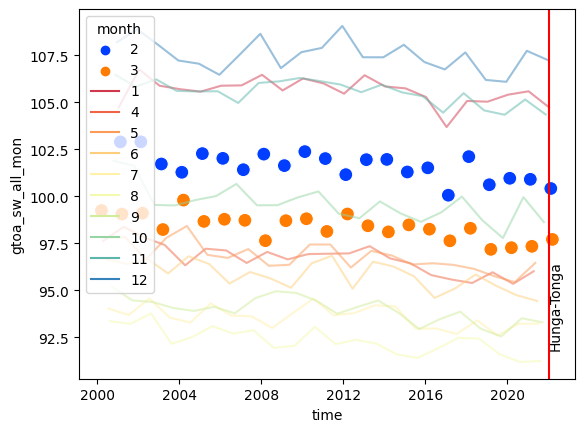

In [76]:
global_mean = dfs[0].copy()
global_mean['month'] = pd.DatetimeIndex(global_mean.index).month
global_mean['year'] = pd.DatetimeIndex(global_mean.index).year
Fglobal_mean=global_mean[(global_mean['month']==2) | (global_mean['month']==3)]
ax=sns.scatterplot(s=100,data=Fglobal_mean.reset_index(),y=Fglobal_mean["gtoa_sw_all_mon"],x=pd.to_datetime(Fglobal_mean.index),hue=Fglobal_mean["month"],palette = sns.color_palette('bright', Fglobal_mean["month"].unique().shape[0]))
Gglobal_mean=global_mean[((global_mean['month']!=2) & (global_mean['month']!=3))]
ax=sns.lineplot(alpha=0.5,data=Gglobal_mean.reset_index(),y=Gglobal_mean["gtoa_sw_all_mon"],x=pd.to_datetime(Gglobal_mean.index),hue=Gglobal_mean["month"],palette = sns.color_palette('Spectral', Gglobal_mean["month"].unique().shape[0]))
ax.axvline(pd.to_datetime("2022-01-15"),c="red",label="Hunga-Tonga")
plt.text(pd.to_datetime("2022-01-15"),92, 'Hunga-Tonga',rotation=90)
sns.move_legend(ax, "upper left")
# plt.savefig(PATH+"Hunga-Tonga_gtoa_sw_all_mon.png")

In [93]:
data_agg.index = pd.to_datetime(data_agg.index)
data_agg_cerres.index = pd.to_datetime(data_agg_cerres.index)


In [98]:
import seaborn as sns
import matplotlib.pyplot as plt
# plt.text(x, .5, 'hello', transform=trans)
# alb = sns.lineplot(data_agg["wsolar_mon"]-data_agg["wtoa_sw_all_mon"],label = "MERRA-2")#,ax = axarrs[0])
alb = sns.lineplot(data_agg_cerres["gtoa_sw_all_mon"],label = "CERES")#,ax = axarrs[0])

# alb.axvline(pd.to_datetime("1991-06-01"),c="red",label="Pinatubo")
# plt.text(pd.to_datetime("1991-10-01"), 245.3, 'Pinatubo')

# alb.axvline(pd.to_datetime("1982-03-01"),c="red")
# plt.text(pd.to_datetime("1982-09-01"), 245.3, 'El Chichón')
plt.title("MERRA-2 Short Wave Reflected Flux")
alb.set_ylabel("Short Wave Reflected Flux")
alb.set_xlabel("Time")

# , 03/28/1982

KeyError: 'gtoa_sw_all_mon'

Text(0, 0.5, '12-step rolling avg. Shortwave Reflected Flu')

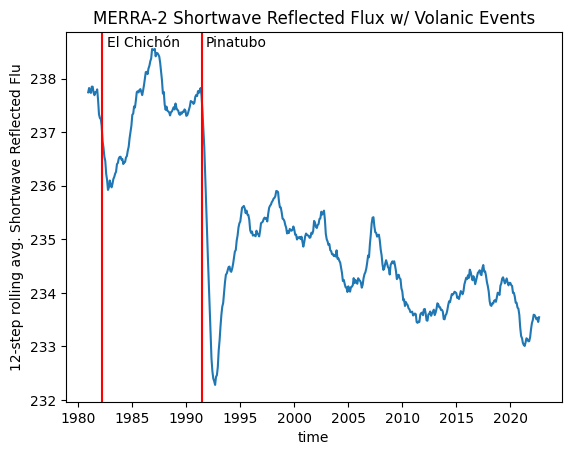

In [72]:
alb = sns.lineplot(data_agg["SWTNT"].rolling(window=12).mean() )#,ax = axarrs[0])
alb.axvline(pd.to_datetime("1991-06-01"),c="red",label="Pinatubo")
plt.text(pd.to_datetime("1991-10-01"), 238.6, 'Pinatubo')

alb.axvline(pd.to_datetime("1982-03-01"),c="red")
plt.text(pd.to_datetime("1982-09-01"), 238.6, 'El Chichón')
plt.title("MERRA-2 Shortwave Reflected Flux w/ Volanic Events")
alb.set_ylabel("12-step rolling avg. Shortwave Reflected Flu")


In [73]:
# data_agg_cerres["albedo"]
data_agg.index = pd.to_datetime(data_agg.index).strftime('%Y-%m')
data_agg_cerres.index = pd.to_datetime(data_agg_cerres.index).strftime('%Y-%m')


In [34]:
absolute_difference = (data_agg_cerres["albedo"]-data_agg["albedo"]).dropna()

In [35]:
percentage_difference = 100*((data_agg_cerres["albedo"]-data_agg["albedo"])/(data_agg_cerres["albedo"])).dropna()

In [36]:
percentage_difference.index  = pd.to_datetime(percentage_difference.index)
absolute_difference.index  = pd.to_datetime(absolute_difference.index)

In [37]:
cerres = data_agg_cerres["albedo"]
cerres.index = pd.to_datetime(cerres.index)

In [38]:
merra2 = data_agg["albedo"]
merra2.index = pd.to_datetime(merra2.index)

In [39]:
albedo_merge = pd.merge(cerres,merra2,left_index=True,right_index=True,)

In [40]:
albedo_merge.reset_index(drop=True,inplace=True)

In [41]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(albedo_merge["albedo_x"],albedo_merge["albedo_y"],squared=False)

0.022405974641946342


Text(2010-01-01 00:00:00, -4, 'RMSE: 2.2e-2')

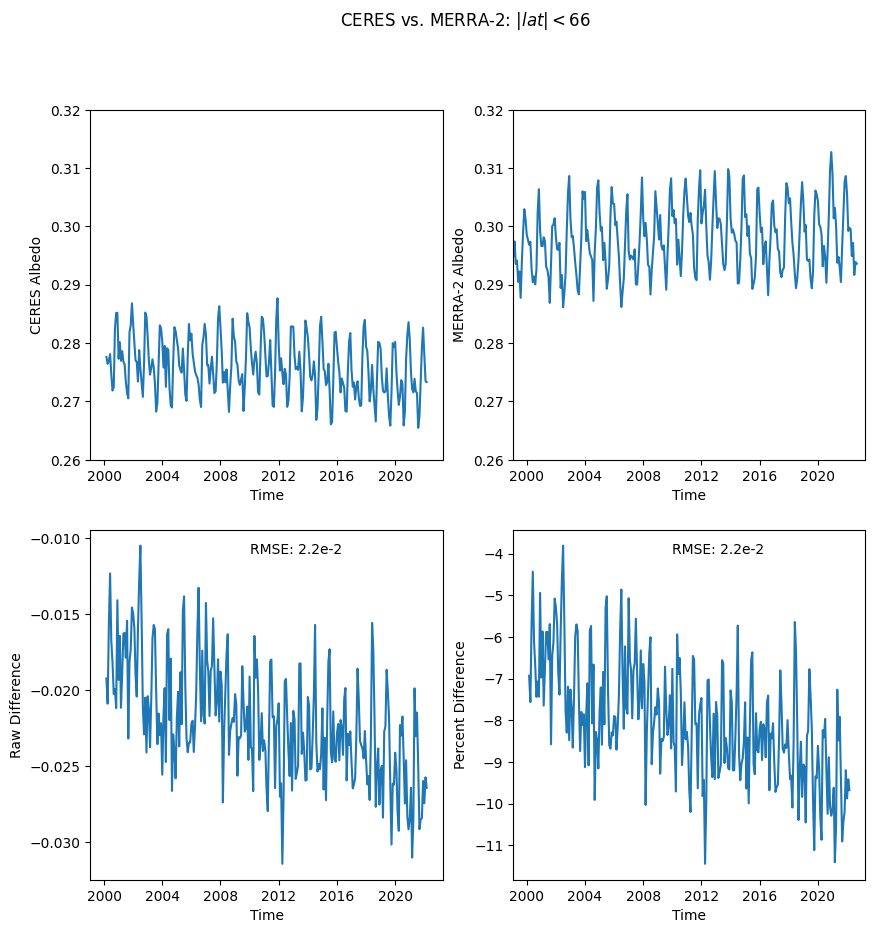

In [42]:
fig, axarrs = plt.subplots(2, 2,figsize=(10,10))
fig.suptitle(r"CERES vs. MERRA-2: $|lat| < 66$", fontsize=12)

print(rmse)
sns.lineplot(cerres,ax=axarrs[0][0])
axarrs[0][0].set_ylabel("CERES Albedo")
axarrs[0][0].set_xlabel("Time")
axarrs[0][0].set_ylim(.26,.32)

sns.lineplot(merra2,ax=axarrs[0][1])
axarrs[0][1].set_ylabel("MERRA-2 Albedo")
axarrs[0][1].set_xlabel("Time")
axarrs[0][1].set_xlim(axarrs[0][0].get_xlim())
axarrs[0][1].set_ylim(.26,.32)

rmse = mean_squared_error(albedo_merge["albedo_x"],
                          albedo_merge["albedo_y"],
                          squared=False)

sns.lineplot(absolute_difference,ax=axarrs[1][0])
axarrs[1][0].set_ylabel("Raw Difference")
axarrs[1][0].set_xlabel("Time")
axarrs[1][0].text(pd.to_datetime(("2010-01-01")),-.011,"RMSE: 2.2e-2")


sns.lineplot(percentage_difference,ax=axarrs[1][1])
axarrs[1][1].set_ylabel("Percent Difference")
axarrs[1][1].set_xlabel("Time")
axarrs[1][1].text(pd.to_datetime(("2010-01-01")),-4,"RMSE: 2.2e-2")


## Clear-sky Shortwave Radiation Albedo 
#### Dan Note: Do you have other variables from MERRA-2?  Do you have clear-sky shortwave flux at TOA like CERES does?  If so, let's produce similar plots to what you produced above, but for clear-sky.  This is another check on MERRA-2.

In [101]:
data_terminator['wtoa_clr_sw_all_mon']=data_terminator['SWTNTCLRCLN']*data_terminator['weights']

/var/folders/8_/qfq2f03j40x2lyrbnm67xqm40000gn/T/ipykernel_7456/2881845929.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_terminator['wtoa_clr_sw_all_mon']=data_terminator['SWTNTCLRCLN']*data_terminator['weights']


In [102]:
data_agg = data_terminator.groupby(level="time").mean()
data_agg["absorb_clr"] = data_agg['wtoa_clr_sw_all_mon']/data_agg['wsolar_mon']
data_agg["albedo_clr"] = 1 - data_agg["absorb_clr"]

In [103]:
data_agg.index  = pd.to_datetime(data_agg.index)

Text(0, 0.5, 'Albedo Clear Sky')

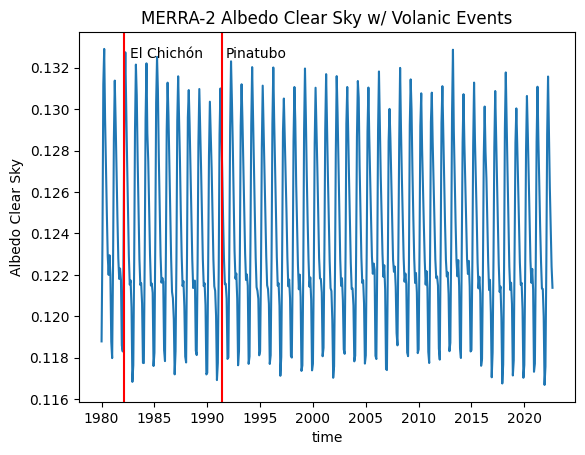

In [104]:
alb_clr = sns.lineplot(data_agg["albedo_clr"])#,ax = axarrs[0])

alb_clr.axvline(pd.to_datetime("1991-06-01"),c="red",label="Pinatubo")
plt.text(pd.to_datetime("1991-10-01"), .1325, 'Pinatubo')

alb_clr.axvline(pd.to_datetime("1982-03-01"),c="red")
plt.text(pd.to_datetime("1982-09-01"), .1325, 'El Chichón')
plt.title("MERRA-2 Albedo Clear Sky w/ Volanic Events")
alb_clr.set_ylabel("Albedo Clear Sky")


# # data_agg_cerres["albedo"]


Text(0, 0.5, '12-step rolling avg. Albedo')

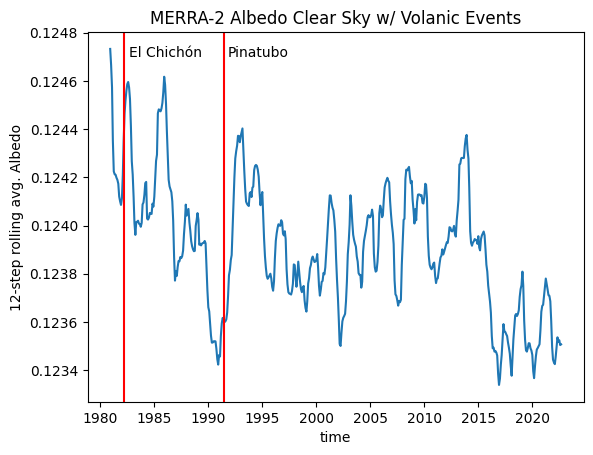

In [105]:
alb_clr = sns.lineplot(data_agg["albedo_clr"].rolling(window=12).mean() )#,ax = axarrs[0])
alb_clr.axvline(pd.to_datetime("1991-06-01"),c="red",label="Pinatubo")

plt.text(pd.to_datetime("1991-10-01"), .1247, 'Pinatubo')

alb_clr.axvline(pd.to_datetime("1982-03-01"),c="red")
plt.text(pd.to_datetime("1982-09-01"), .1247, 'El Chichón')
plt.title("MERRA-2 Albedo Clear Sky w/ Volanic Events")
alb_clr.set_ylabel("12-step rolling avg. Albedo")


0.015891412674672045


Text(2010-01-01 00:00:00, 13, 'RMSE: 1.6e-2')

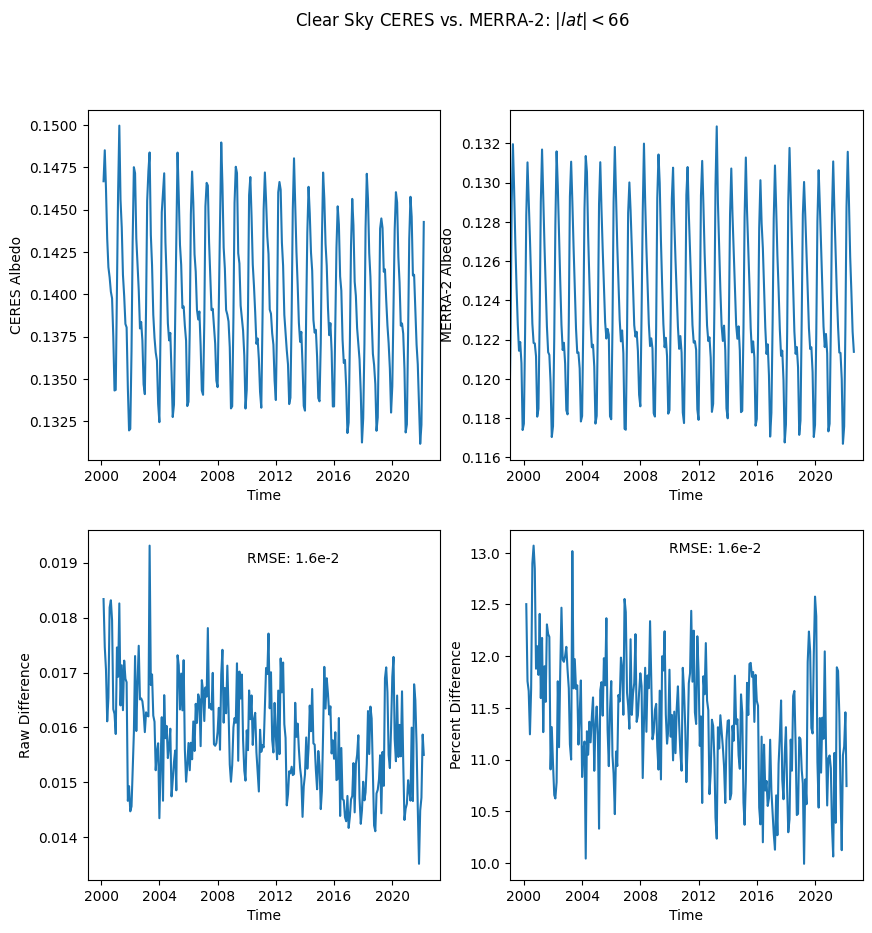

In [109]:
data_agg.index = pd.to_datetime(data_agg.index).strftime('%Y-%m')
data_agg_cerres.index = pd.to_datetime(data_agg_cerres.index).strftime('%Y-%m')


absolute_difference = (data_agg_cerres["albedo_clr"]-data_agg["albedo_clr"]).dropna()

percentage_difference = 100*((data_agg_cerres["albedo_clr"]-data_agg["albedo_clr"])/(data_agg_cerres["albedo_clr"])).dropna()

percentage_difference.index  = pd.to_datetime(percentage_difference.index)
absolute_difference.index  = pd.to_datetime(absolute_difference.index)

cerres = data_agg_cerres["albedo_clr"]
cerres.index = pd.to_datetime(cerres.index)

merra2 = data_agg["albedo_clr"]
merra2.index = pd.to_datetime(merra2.index)

albedo_merge_clr = pd.merge(cerres,merra2,left_index=True,right_index=True,)
albedo_merge_clr.reset_index(drop=True,inplace=True)

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(albedo_merge_clr["albedo_clr_x"],albedo_merge_clr["albedo_clr_y"],squared=False)
print(rmse)
fig, axarrs = plt.subplots(2, 2,figsize=(10,10))
fig.suptitle(r"Clear Sky CERES vs. MERRA-2: $|lat| < 66$", fontsize=12)


sns.lineplot(cerres,ax=axarrs[0][0])
axarrs[0][0].set_ylabel("CERES Albedo")
axarrs[0][0].set_xlabel("Time")
# axarrs[0][0].set_ylim(.11, .15)

sns.lineplot(merra2,ax=axarrs[0][1])
axarrs[0][1].set_ylabel("MERRA-2 Albedo")
axarrs[0][1].set_xlabel("Time")
axarrs[0][1].set_xlim(axarrs[0][0].get_xlim())
# axarrs[0][0].set_ylim(.11, .15)

rmse = mean_squared_error(albedo_merge_clr["albedo_clr_x"],
                          albedo_merge_clr["albedo_clr_y"],
                          squared=False)

sns.lineplot(absolute_difference,ax=axarrs[1][0])
axarrs[1][0].set_ylabel("Raw Difference")
axarrs[1][0].set_xlabel("Time")
axarrs[1][0].text(pd.to_datetime(("2010-01-01")),.019,"RMSE: 1.6e-2")


sns.lineplot(percentage_difference,ax=axarrs[1][1])
axarrs[1][1].set_ylabel("Percent Difference")
axarrs[1][1].set_xlabel("Time")
axarrs[1][1].text(pd.to_datetime(("2010-01-01")),13,"RMSE: 1.6e-2")


# Bayesian Structural Time Series Adative Impact

In [ ]:
regressor_dfs = []
for index, group in data.groupby(level="lat"):
    print("-"*100)
    print(index)
    group = group.groupby("time").mean().interpolate()
    
    group["ds"] = group.index
    group["y"] = ngroup.ALBEDO
    group.drop(["ALBEDO"],axis=1,inplace=True)
    m = Prophet()

    for col in group.columns:
        if col not in ["y","ds"]:
            m.add_regressor(col)
    m.fit(group)
    regressor_df = regressor_coefficients(m)
    regressor_df["lat"]  = index
    regressor_dfs.append(regressor_df)
    

In [ ]:
regressor_dfs_concat = pd.concat(regressor_dfs)

In [ ]:
regressor_dfs_concat

In [ ]:
import matplotlib.pyplot as plt
subset = regressor_dfs_concat[regressor_dfs_concat["regressor"] == "CLDHGH"].reset_index(drop=True)
unique_labels = regressor_dfs_concat["regressor"].unique()

In [ ]:
axarr[0][0]

In [ ]:
fig, axarr = plt.subplots(2, 4,figsize=(30,15))
print(axarr)
i=0
for label in unique_labels:
    subset = regressor_dfs_concat[regressor_dfs_concat["regressor"] == label]
    if i<=3:
        plot_ax = axarr[0][i]
    else:
        plot_ax = axarr[1][i-4]
    sns.lineplot(x="lat",y="coef",data = subset,ax=plot_ax)
    plot_ax.set_ylabel(f"Additive Impact of Unit increase in {label} on Albedo")
    plot_ax.set_xlabel(f"Latitude")
    plot_ax.set_title(f"Additive Impact of {label} on Albedo vs. Latitude")


    i+=1

In [ ]:
regressor_dfs_log = []

for index, group in data_log.groupby(level="lat"):
    print("-"*100)
    print(index)
    group = group.groupby("time").mean().interpolate()
    
    group["ds"] = group.index
    group["y"] = group.ALBEDO
    group.drop(["ALBEDO"],axis=1,inplace=True)
    m = Prophet()

    for col in group.columns:
        if col not in ["y","ds"]:
            m.add_regressor(col)
    
    m.fit(group.dropna()) #quick and dirty hack to handle NaNs
    regressor_df = regressor_coefficients(m)
    regressor_df["lat"]  = index
    regressor_dfs_log.append(regressor_df)

In [ ]:
regressor_dfs_concat_log = pd.concat(regressor_dfs_log)
fig, axarr = plt.subplots(2, 4,figsize=(30,15))
print(axarr)
i=0
for label in unique_labels:
    subset = regressor_dfs_concat_log[regressor_dfs_concat_log["regressor"] == label]
    if i<=3:
        plot_ax = axarr[0][i]
    else:
        plot_ax = axarr[1][i-4]
    sns.lineplot(x="lat",y="coef",data = subset,ax=plot_ax)
    plot_ax.set_ylabel(f"Additive Impact of {label} on Albedo")
    plot_ax.set_xlabel(f"Latitude")
    plot_ax.set_title(f"Additive Impact of {label} on Albedo vs. Latitude")


    i+=1

In [ ]:
group

In [ ]:
weights = []
for index, group in data.groupby(level="lat"):
    weight = lat_weight(index)
    weights.append(weight)

In [ ]:
i=0 
for index, group in data.groupby(level="lat"):
    data.loc[(slice(None), index,slice(None)),"weights"] = weights[i] 
    i+=1


In [ ]:
data['wtoa_sw_all_mon']=data['SWTNT']*data['weights']
data['wsolar_mon']=data['SWGDN']*data['weights']
fig, axarrs = plt.subplots(1, 2,figsize=(18,6))
fig.suptitle("Our Calculation vs. Global Means", fontsize=14)

data_agg = data.groupby(level="time").mean()
data_agg["albedo"] = data_agg['wtoa_sw_all_mon']/data_agg['wsolar_mon']
sns.lineplot(data_agg["albedo"],label="Our Calculation",ax = axarrs[0])
# axarrs[0].text(pd.to_datetime(2016), 0.3,'Text Here', fontsize=9) 
sns.lineplot(global_mean["albedo"],label="Global Mean",ax = axarrs[1],c="red")

# sns.lineplot(data_agg["albedo"],label="Our Calculation",ax = axarrs[2])
sns.lineplot(global_mean["albedo"],label="Global Mean",ax = axarrs[2],c="red")

In [ ]:
fig, axarrs = plt.subplots(1, 2,figsize=(18,6))
fig.suptitle("Our Calculation vs. Global Means", fontsize=14)

data_agg = data.groupby(level="time").mean()
data_agg["albedo"] = data_agg['wtoa_sw_all_mon']/data_agg['wsolar_mon']
sns.lineplot(data_agg["albedo"],label="Our Calculation",ax = axarrs[0])
# axarrs[0].text(pd.to_datetime(2016), 0.3,'Text Here', fontsize=9) 
sns.lineplot(global_mean["albedo"],label="Global Mean",ax = axarrs[1],c="red")

# sns.lineplot(data_agg["albedo"],label="Our Calculation",ax = axarrs[2])
sns.lineplot(global_mean["albedo"],label="Global Mean",ax = axarrs[2],c="red")

In [ ]:
data_agg

In [ ]:
d

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
time_data = data.groupby(level="time").mean()
sns.lineplot(time_data.ALBEDO)
plt.title("MERRA-2")

In [ ]:
sns.lineplot(time_data.SWGDN)
plt.title("MERRA-2")

# Globally Average Data Pull

In [22]:
f_avg = "CERES_EBAF-TOA_Ed4.1_Subset_200003-202203.nc"
f_lat_lon = "CERES_EBAF-TOA_Ed4.1_Subset_200003-202203-lat-lon.nc"

f_names = [f_avg,f_lat_lon]
def load_netcdf(f_path:str)-> pd.DataFrame:
    ds = xr.open_dataset(f_path)
    df = ds.to_dataframe()
    
    return df
dfs = [load_netcdf(os.path.join("../data",f_name)) for f_name in f_names]

<AxesSubplot: xlabel='time', ylabel='albedo'>

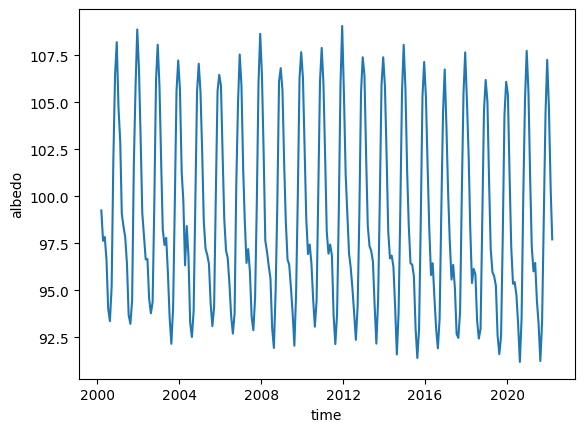

In [102]:
import seaborn as sns 
import matplotlib.pyplot as plt
global_mean = dfs[0].copy()
global_mean["albedo"] = global_mean["gtoa_sw_all_mon"]

#  (TOA outgoing flux)/(solar flux)
sns.lineplot(global_mean["albedo"])

# LAT-LON GRID PULL


## Surface Area correction

In [103]:
import numpy as np 
import math 
Rearth = 6378.137
delta_lat=1
delta_lon=1


In [104]:
def lat_weight(lat:float) -> float:
    return abs(np.sin(np.radians(lat-0.5))-np.sin(np.radians(lat+0.5)))

In [105]:
data_cerres = dfs[1].copy()
data_cerres = data_cerres.query('lat > -66 & lat <66')
weights = []
for index, group in data_cerres.groupby(level="lat"):
    weight = lat_weight(index)
    weights.append(weight)

In [106]:
data_cerres["albedo"] = data_cerres["toa_sw_all_mon"]/data_cerres["solar_mon"]
data_cerres["albedo_clr"] = data_cerres["toa_sw_clr_c_mon"]/data_cerres["solar_mon"]

In [113]:
data_cerres["wtoa_sw_all_mon"]

lon    lat    time      
0.5    -89.5  2000-03-15    0.006679
              2000-04-15    0.000025
              2000-05-15    0.000007
              2000-06-15    0.000007
              2000-07-15    0.000007
                              ...   
359.5   89.5  2021-11-15    0.000007
              2021-12-15    0.000000
              2022-01-15    0.000007
              2022-02-15    0.000012
              2022-03-15    0.002425
Name: wtoa_sw_all_mon, Length: 17172000, dtype: float64

In [107]:
assert len(set(data_cerres.index.get_level_values("lat"))) == len(weights)

In [108]:
i=0 
for index, group in data_cerres.groupby(level="lat"):
    data_cerres.loc[(slice(None), index,slice(None)),"weights"] = weights[i] 
    i+=1


In [109]:
data_cerres['wtoa_sw_all_mon']=data_cerres['toa_sw_all_mon']*data_cerres['weights']
data_cerres['wtoa_sw_clr_c_all_mon']=data_cerres['toa_sw_clr_c_mon']*data_cerres['weights']
data_cerres['wsolar_mon']=data_cerres['solar_mon']*data_cerres['weights']

<AxesSubplot: xlabel='time', ylabel='wtoa_sw_all_mon'>

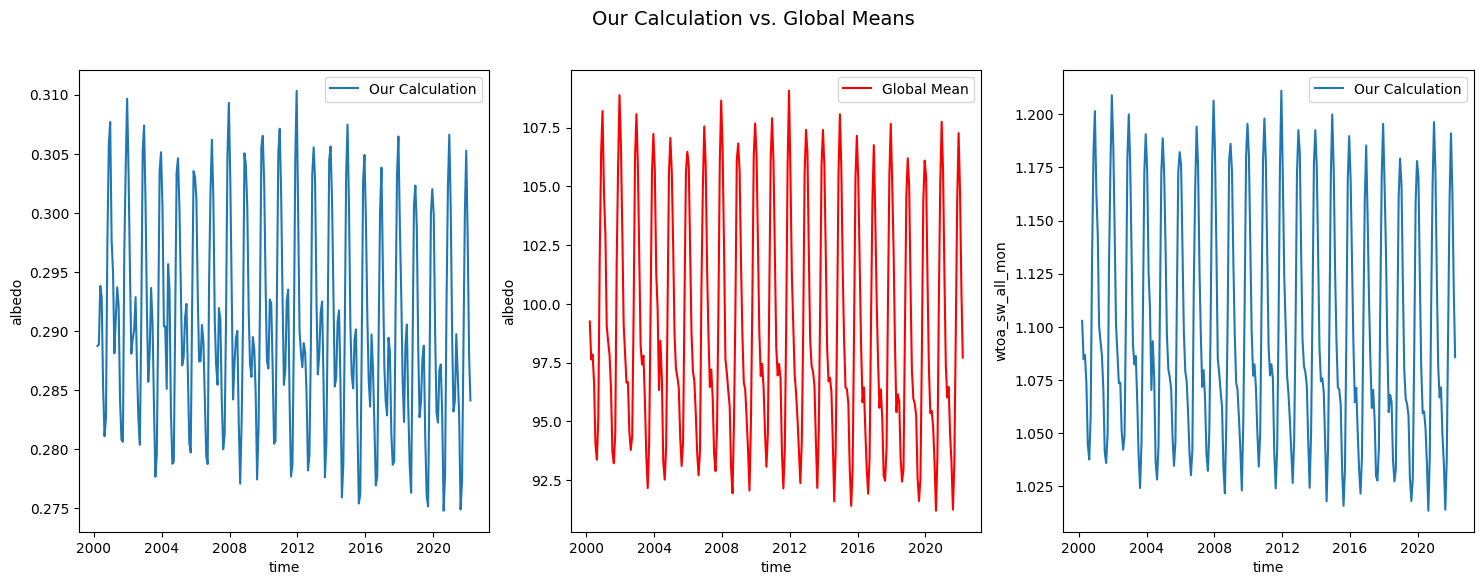

In [116]:
fig, axarrs = plt.subplots(1, 3,figsize=(18,6))
fig.suptitle("Our Calculation vs. Global Means", fontsize=14)

data_agg_cerres = data_cerres.groupby(level="time").mean()
data_agg_cerres["albedo"] = data_agg_cerres['wtoa_sw_all_mon']/data_agg_cerres['wsolar_mon']
data_agg_cerres["albedo_clr"] = data_agg_cerres['wtoa_sw_clr_c_all_mon']/data_agg_cerres['wsolar_mon']

sns.lineplot(data_agg_cerres["albedo"],label="Our Calculation",ax = axarrs[0])
# axarrs[0].text(pd.to_datetime(2016), 0.3,'Text Here', fontsize=9) 
sns.lineplot(global_mean["albedo"],label="Global Mean",ax = axarrs[1],c="red")

sns.lineplot(data_agg_cerres["wtoa_sw_all_mon"],label="Our Calculation",ax = axarrs[2])
# sns.lineplot(global_mean["albedo"],label="Global Mean",ax = axarrs[2],c="red")

In [117]:
data_cerres

toa_sw_all_mon  toa_lw_all_mon  toa_net_all_mon  \
lon   lat   time                                                          
0.5   -89.5 2000-03-15       43.849998      139.600006      -126.400002   
            2000-04-15        0.162000      123.900002      -124.099998   
            2000-05-15        0.049000      120.400002      -120.500000   
            2000-06-15        0.047000      116.900002      -116.900002   
            2000-07-15        0.049000      112.400002      -112.400002   
...                                ...             ...              ...   
359.5  89.5 2021-11-15        0.049000      174.600006      -174.699997   
            2021-12-15        0.000000      172.100006      -172.100006   
            2022-01-15        0.049000      164.899994      -164.899994   
            2022-02-15        0.076000      169.899994      -170.000000   
            2022-03-15       15.920000      177.699997      -173.899994   

                        toa_sw_clr_c_mon  toa_lw_clr_c_mon  toa_net_clr_c_mon  \
lon   lat   time                                                                
0.5   -89.5 2000-03-15         64.470001        136.600006        -143.899994   
            2000-04-15          0.023000        120.000000        -120.000000   
            2000-05-15          0.000000        114.400002        -114.400002   
            2000-06-15          0.001000        113.000000        -113.000000   
            2000-07-15          0.001000        106.500000        -106.500000   
...                                  ...               ...                ...   
359.5  89.5 2021-11-15          0.104000        180.800003        -180.899994   
            2021-12-15          0.011000        175.899994        -176.000000   
            2022-01-15          0.006000        169.100006        -169.100006   
            2022-02-15          0.019000        171.300003        -171.300003   
            2022-03-15         38.549999        178.399994        -197.199997   

                        solar_mon  cldarea_total_daynight_mon  \
lon   lat   time                                                
0.5   -89.5 2000-03-15  57.130001                   39.996902   
            2000-04-15   0.000000                   29.147787   
            2000-05-15   0.000000                   39.199551   
            2000-06-15   0.000000                   33.485081   
            2000-07-15   0.000000                   54.086681   
...                           ...                         ...   
359.5  89.5 2021-11-15   0.000000                   82.046333   
            2021-12-15   0.000000                   77.764137   
            2022-01-15   0.000000                   74.473236   
            2022-02-15   0.000000                   87.296547   
            2022-03-15  19.719999                   78.724976   

                        cldpress_total_daynight_mon  \
lon   lat   time                                      
0.5   -89.5 2000-03-15                   540.877380   
            2000-04-15                   581.843079   
            2000-05-15                   525.753479   
            2000-06-15                   412.346252   
            2000-07-15                   450.323853   
...                                             ...   
359.5  89.5 2021-11-15                   815.663879   
            2021-12-15                   815.907471   
            2022-01-15                   761.559875   
            2022-02-15                   780.518921   
            2022-03-15                   741.112488   

                        cldtemp_total_daynight_mon  cldtau_total_day_mon  \
lon   lat   time                                                           
0.5   -89.5 2000-03-15                  228.533188              6.037879   
            2000-04-15                  221.777603                   NaN   
            2000-05-15                  223.629944                   NaN   
            2000-06-15                  217.672714  

/Users/samuelkahn/Desktop/ClimateAIResearch/climate-ai/lib/python3.9/site-packages/seaborn/_oldcore.py:786: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  plot_data = pd.DataFrame(plot_data)
/Users/samuelkahn/Desktop/ClimateAIResearch/climate-ai/lib/python3.9/site-packages/seaborn/relational.py:438: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  sub_data = grouped.apply(agg, other).reset_index()


ValueError: cannot insert x, already exists

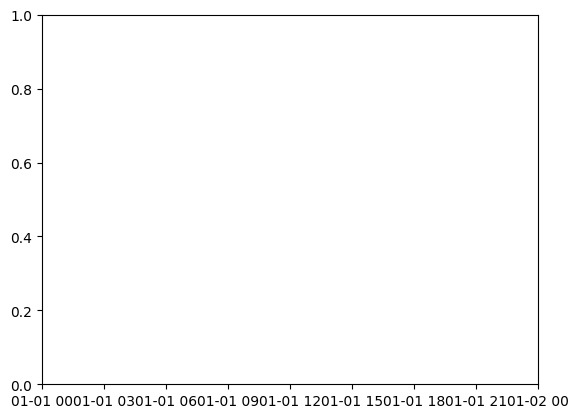

In [32]:
sns.lineplot(global_mean["albedo"]-data_agg["albedo"])
plt.title("Absolute Difference")
plt.ylabel("Global Mean - Our Calculation")

### Looks better! 

# Additive Impact 

In [ ]:
import multiprocessing
# multiprocessing.set_start_method("fork")
regressor_dfs = []
for index, group in data.groupby(level="lat"):
    print("-"*100)
    print(index)
    group = group.groupby("time").mean()
    group["weighted_albedo"] = (group['wtoa_sw_all_mon']/group['wsolar_mon']).astype(float)
    group["y"] = group.weighted_albedo
    group.replace([np.inf, -np.inf], np.nan,inplace = True)
    group = group.interpolate()
    group["ds"] = group.index
    print(group["y"])
    group.drop(["weighted_albedo",
                "wtoa_sw_all_mon",
                "wsolar_mon",
                "toa_sw_all_mon",
                "solar_mon",
                "albedo",
                "weights"],axis=1,inplace=True)
    m = Prophet(mcmc_samples=1000)

    for col in group.columns:
        if col not in ["y","ds"]:
            m.add_regressor(col)
    m.fit(group)
    regressor_df = regressor_coefficients(m)
    regressor_df["lat"]  = index
    regressor_dfs.append(regressor_df)

In [ ]:
import matplotlib.pyplot as plt
# subset = regressor_dfs_concat[regressor_dfs_concat["regressor"] == "CLDHGH"].reset_index(drop=True)
regressor_dfs_concat = pd.concat(regressor_dfs)
unique_labels = regressor_dfs_concat["regressor"].unique()


In [ ]:
subset_range = False
fig, axarr = plt.subplots(3, 3,figsize=(30,20))
idx=0
for i in range(0,len(axarr)):
    for j in range(0,len(axarr[i])):
        label=unique_labels[idx]
        subset = regressor_dfs_concat[regressor_dfs_concat["regressor"] == label]

        sns.lineplot(x="lat",y="coef",data = subset,ax=axarr[i][j])
        sns.lineplot(x="lat",y="coef_upper",data = subset,ax=axarr[i][j])
        sns.lineplot(x="lat",y="coef_lower",data = subset,ax=axarr[i][j])
        axarr[i][j].fill_between(subset["lat"], subset["coef_lower"], subset["coef_upper"], alpha=.3)

        axarr[i][j].set_ylabel(f"Additive Impact of Unit increase in {label} on Albedo")
        axarr[i][j].set_xlabel(f"Latitude")
        axarr[i][j].set_title(f"Additive Impact of {label} on Albedo vs. Latitude")  
        if subset_range:
            axarr[i][j].set_ylim(-.005,.005)
        idx+=1


In [ ]:
fig, axarr = plt.subplots(3, 3,figsize=(30,30))
idx=0
for i in range(0,len(axarr)):
    for j in range(0,len(axarr[i])):
        label=unique_labels[idx]
        subset = regressor_dfs_concat[regressor_dfs_concat["regressor"] == label]
        subset = subset[np.abs(subset["lat"])<50]
#         axarr[i][j].set_xlim(-50,50)
#         axarr[i][j].set_ylim(-.002,.002)
        sns.lineplot(x="lat",y="coef",data = subset,ax=axarr[i][j])
#         sns.lineplot(x="lat",y="coef_upper",data = subset,ax=axarr[i][j])
#         sns.lineplot(x="lat",y="coef_lower",data = subset,ax=axarr[i][j])
        axarr[i][j].fill_between(subset["lat"], subset["coef_lower"], subset["coef_upper"], alpha=.3)

        axarr[i][j].set_ylabel(f"Additive Impact of Unit increase in {label} on Albedo")
        axarr[i][j].set_xlabel(f"Latitude")
        axarr[i][j].set_title(f"Additive Impact of {label} on Albedo vs. Latitude")
        idx+=1


## Quick high/low Latitude Instability Investigation

In [ ]:
isna = []
for index, group in data.groupby(level="lat"):
    group["weighted_albedo"] = (group['wtoa_sw_all_mon']/group['wsolar_mon']).astype(float)
    group.replace([np.inf, -np.inf], np.nan,inplace = True)
#     print(group)
    isna.append({"lat":index,"na_count": group["weighted_albedo"].isna().sum()})
#     break

In [ ]:
isna_df = pd.DataFrame(isna)
sns.lineplot(x = "lat",y="na_count",data=isna_df)


In [ ]:
### It appears the instability is likely due to the interpolation that we're using to fill in missing values in the time series

# Temporal Stability

In [ ]:
data_t0 = data.xs(slice('2000-03-15', '2010-01-01'), level='time',drop_level=False)
data_t1 = data.xs(slice('2010-01-01', data.index[-1][2]), level='time',drop_level=False)

In [ ]:
import multiprocessing
# multiprocessing.set_start_method("fork")
regressor_dfs_t0 = []
for index, group in data_t0.groupby(level="lat"):
    print("-"*100)
    print(index)
    group = group.groupby("time").mean()
    group["weighted_albedo"] = (group['wtoa_sw_all_mon']/group['wsolar_mon']).astype(float)
    group["y"] = group.weighted_albedo
    group.replace([np.inf, -np.inf], np.nan,inplace = True)
    group = group.interpolate()
    group["ds"] = group.index
    print(group["y"])
    group.drop(["weighted_albedo",
                "wtoa_sw_all_mon",
                "wsolar_mon",
                "toa_sw_all_mon",
                "solar_mon",
                "albedo",
                "weights"],axis=1,inplace=True)
    m = Prophet(mcmc_samples=1000)

    for col in group.columns:
        if col not in ["y","ds"]:
            m.add_regressor(col)
    m.fit(group)
    regressor_df = regressor_coefficients(m)
    regressor_df["lat"]  = index
    regressor_dfs_t0.append(regressor_df)

In [ ]:
import multiprocessing
# multiprocessing.set_start_method("fork")
regressor_dfs_t1 = []
for index, group in data_t1.groupby(level="lat"):
    print("-"*100)
    print(index)
    group = group.groupby("time").mean()
    group["weighted_albedo"] = (group['wtoa_sw_all_mon']/group['wsolar_mon']).astype(float)
    group["y"] = group.weighted_albedo
    group.replace([np.inf, -np.inf], np.nan,inplace = True)
    group = group.interpolate()
    group["ds"] = group.index
    print(group["y"])
    group.drop(["weighted_albedo",
                "wtoa_sw_all_mon",
                "wsolar_mon",
                "toa_sw_all_mon",
                "solar_mon",
                "albedo",
                "weights"],axis=1,inplace=True)
    m = Prophet(mcmc_samples=1000)

    for col in group.columns:
        if col not in ["y","ds"]:
            m.add_regressor(col)
    m.fit(group)
    regressor_df = regressor_coefficients(m)
    regressor_df["lat"]  = index
    regressor_dfs_t1.append(regressor_df)

## T < 2010-01-01

In [ ]:
regressor_dfs_concat_t0 = pd.concat(regressor_dfs_t0)
unique_labels = regressor_dfs_concat_t0["regressor"].unique()

fig, axarr = plt.subplots(3, 3,figsize=(30,30))
idx=0
for i in range(0,len(axarr)):
    for j in range(0,len(axarr[i])):
        label=unique_labels[idx]
        subset = regressor_dfs_concat_t0[regressor_dfs_concat_t0["regressor"] == label]
        subset = subset[np.abs(subset["lat"])<50]
#         axarr[i][j].set_xlim(-50,50)
#         axarr[i][j].set_ylim(-.002,.002)
        sns.lineplot(x="lat",y="coef",data = subset,ax=axarr[i][j])
#         sns.lineplot(x="lat",y="coef_upper",data = subset,ax=axarr[i][j])
#         sns.lineplot(x="lat",y="coef_lower",data = subset,ax=axarr[i][j])
        axarr[i][j].fill_between(subset["lat"], subset["coef_lower"], subset["coef_upper"], alpha=.3)

        axarr[i][j].set_ylabel(f"Additive Impact of Unit increase in {label} on Albedo")
        axarr[i][j].set_xlabel(f"Latitude")
        axarr[i][j].set_title(f"Additive Impact of {label} on Albedo vs. Latitude")
        idx+=1


## T >= 2010-01-01

In [ ]:
regressor_dfs_concat_t1 = pd.concat(regressor_dfs_t1)
unique_labels = regressor_dfs_concat_t1["regressor"].unique()

fig, axarr = plt.subplots(3, 3,figsize=(30,30))
idx=0
for i in range(0,len(axarr)):
    for j in range(0,len(axarr[i])):
        label=unique_labels[idx]
        subset = regressor_dfs_concat_t1[regressor_dfs_concat_t1["regressor"] == label]
        subset = subset[np.abs(subset["lat"])<50]
#         axarr[i][j].set_xlim(-50,50)
#         axarr[i][j].set_ylim(-.002,.002)
        sns.lineplot(x="lat",y="coef",data = subset,ax=axarr[i][j])
#         sns.lineplot(x="lat",y="coef_upper",data = subset,ax=axarr[i][j])
#         sns.lineplot(x="lat",y="coef_lower",data = subset,ax=axarr[i][j])
        axarr[i][j].fill_between(subset["lat"], subset["coef_lower"], subset["coef_upper"], alpha=.3)

        axarr[i][j].set_ylabel(f"Additive Impact of Unit increase in {label} on Albedo")
        axarr[i][j].set_xlabel(f"Latitude")
        axarr[i][j].set_title(f"Additive Impact of {label} on Albedo vs. Latitude")
        idx+=1


## Overplot 

In [ ]:
plot_cis = True
fig, axarr = plt.subplots(3, 3,figsize=(30,30))
idx=0
for i in range(0,len(axarr)):
    for j in range(0,len(axarr[i])):
        label=unique_labels[idx]
        subset_t0 = regressor_dfs_concat_t0[regressor_dfs_concat_t0["regressor"] == label]
        subset_t0 = subset_t0[np.abs(subset_t0["lat"])<50]
        
        subset_t1 = regressor_dfs_concat_t1[regressor_dfs_concat_t1["regressor"] == label]
        subset_t1 = subset_t1[np.abs(subset_t1["lat"])<50]

        sns.lineplot(x="lat",y="coef",data = subset_t0,ax=axarr[i][j],label="T >= 2010-01-01")
        sns.lineplot(x="lat",y="coef",data = subset_t1,ax=axarr[i][j],label="T < 2010-01-01")

#         sns.lineplot(x="lat",y="coef_upper",data = subset,ax=axarr[i][j])
#         sns.lineplot(x="lat",y="coef_lower",data = subset,ax=axarr[i][j])
        if plot_cis:
            axarr[i][j].fill_between(subset_t0["lat"], subset_t0["coef_lower"], subset_t0["coef_upper"], alpha=.3)
            axarr[i][j].fill_between(subset_t1["lat"], subset_t1["coef_lower"], subset_t1["coef_upper"], alpha=.3)

        axarr[i][j].set_ylabel(f"Additive Impact of Unit increase in {label} on Albedo")
        axarr[i][j].set_xlabel(f"Latitude")
        axarr[i][j].set_title(f"Additive Impact of {label} on Albedo vs. Latitude")
        idx+=1


# 10/13/2022 - Notes from Meeting with Dan 
## - 